# Imports

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import zipfile
import pydicom
import cv2
import json
from sklearn.model_selection import StratifiedGroupKFold

# Stats of csv

In [4]:
annotations_df=pd.read_csv('../data/MIDRC mRALE Mastermind Training Annotations_2079_20230428.csv')

In [3]:
print(annotations_df.head())

                                    StudyInstanceUID extent_right  \
0  1.2.826.0.1.3680043.10.474.419639.280560458539...         >75%   
1  1.2.826.0.1.3680043.10.474.419639.316579237354...       51-75%   
2  1.2.826.0.1.3680043.10.474.419639.119686652556...        <=25%   
3  1.2.826.0.1.3680043.10.474.419639.427770385556...         None   
4  1.2.826.0.1.3680043.10.474.419639.298049151358...         None   

  density_right extent_left density_left quality_issue  \
0         Dense        >75%     Moderate           NaN   
1         Dense      51-75%     Moderate           NaN   
2          Hazy       <=25%         Hazy           NaN   
3          None        None         None           NaN   
4          None        None         None           NaN   

   extent_right_numerical  density_right_numerical  extent_left_numerical  \
0                       4                        3                      4   
1                       3                        3                      3   
2    

## Label distribution

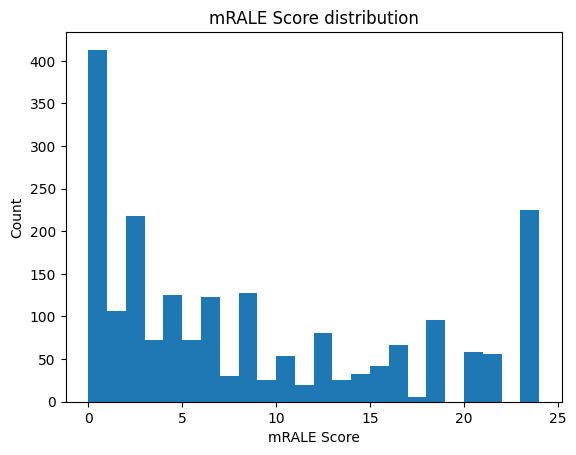

In [4]:
plt.hist(annotations_df['mRALE Score'],[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24])
plt.xlabel("mRALE Score");
plt.ylabel("Count");
plt.title("mRALE Score distribution");

In [3]:
int(annotations_df.query('StudyInstanceUID =="1.2.826.0.1.3680043.10.474.419639.847738872132888982802877633658"')['mRALE Score'])

NameError: name 'annotations_df' is not defined

# Resized version of images

In [5]:
total_dcm_files=0
label_json_file=[]
for subdir, dirs, files in os.walk('../data/original'):
    for file in files:
        if file[-3:]=="zip":
            with zipfile.ZipFile(subdir+'/'+file) as zf:
                for cur_file in zf.namelist():
                    if cur_file.endswith('.dcm'): # optional filtering by filetype
                        # print(cur_file)
                        total_dcm_files+=1     
                        cur_dict_info=dict() 
                        with zf.open(cur_file) as cur_dcm_file:
                            dcm_file=pydicom.dcmread(cur_dcm_file)
                            if len((dcm_file.pixel_array.shape))!=2:
                                print("Wrong here")
                            cur_img_array=dcm_file.pixel_array
                            mrale_score=float(annotations_df.query('StudyInstanceUID =='+'"'+dcm_file.StudyInstanceUID+'"')['mRALE Score'])
                            cur_img_array=cur_img_array/np.max(cur_img_array)
                            cur_img_array*=255.0
                            cur_img_array=cur_img_array.astype('uint8')
                            full_img_file_name=dcm_file.PatientID+\
                                '_'+dcm_file.StudyInstanceUID+\
                                '_'+dcm_file.SeriesInstanceUID+\
                                '_'+dcm_file.SOPInstanceUID+'.png'
                            resized_img=cv2.resize(cur_img_array,(512,512))
                            
                            cv2.imwrite('../data/resized_512X512/data/'+full_img_file_name,resized_img)
                            cur_dict_info['PatientID']=dcm_file.PatientID
                            cur_dict_info['StudyInstanceUID']=dcm_file.StudyInstanceUID
                            cur_dict_info['SeriesInstanceUID']=dcm_file.SeriesInstanceUID
                            cur_dict_info['SOPInstanceUID']=dcm_file.SOPInstanceUID
                            cur_dict_info['full_image_name']=full_img_file_name
                            cur_dict_info['mRALE Score']=mrale_score
                            label_json_file.append(cur_dict_info)
                            
                            
                            


# with open('../data/resized_224X224/label_info/labels.json',"w") as label_info:
#     json.dump(label_json_file,label_info,indent=4)

print(total_dcm_files)

2598


In [7]:
# len(os.listdir('../data/resized_224X224/data'))

# 5 Fold patient level split

Fold:  1
Train Indices:
2078
---------------
Val indices:
520
-------------
Fold:  2
Train Indices:
2096
---------------
Val indices:
502
-------------
Fold:  3
Train Indices:
2050
---------------
Val indices:
548
-------------
Fold:  4
Train Indices:
2072
---------------
Val indices:
526
-------------
Fold:  5
Train Indices:
2096
---------------
Val indices:
502
-------------


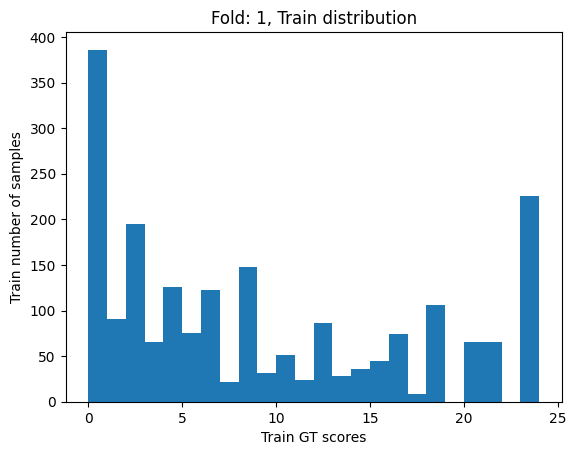

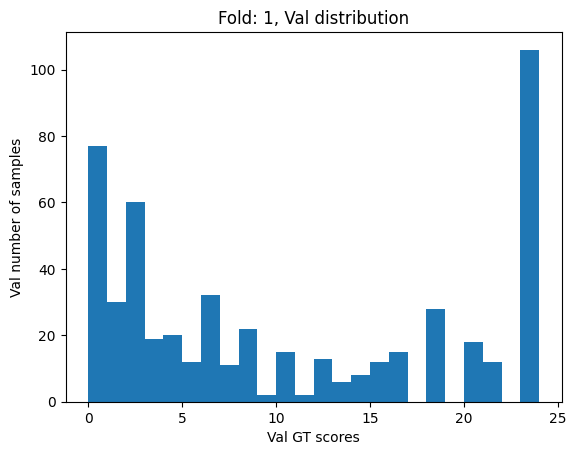

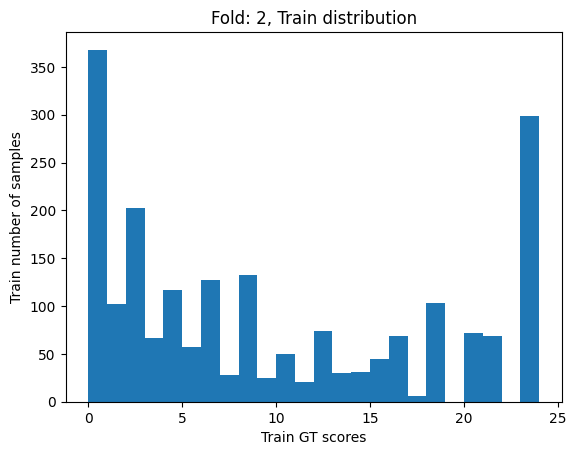

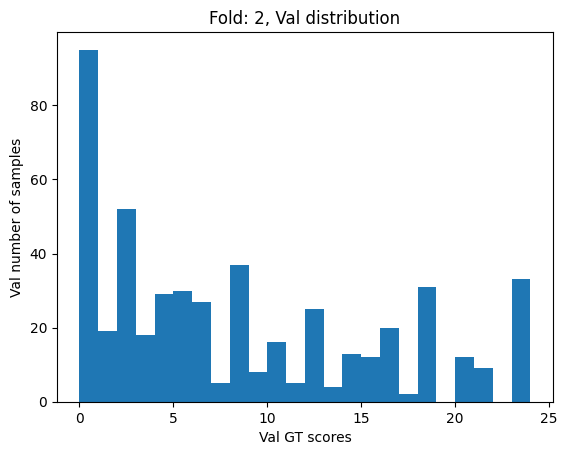

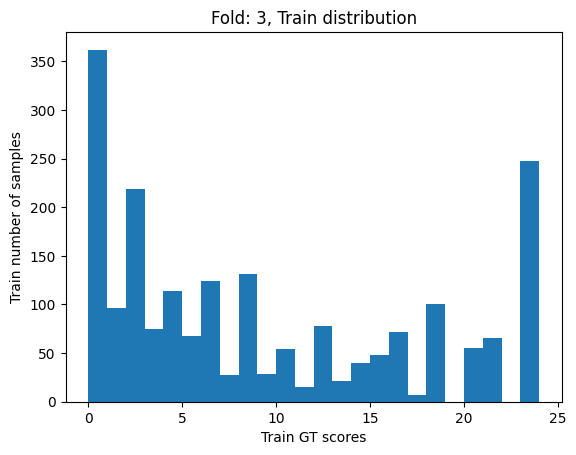

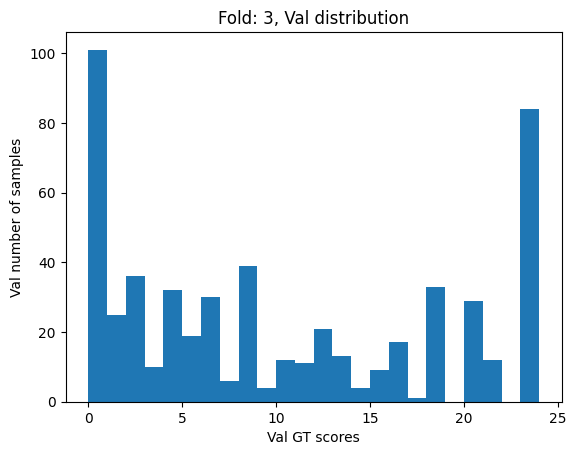

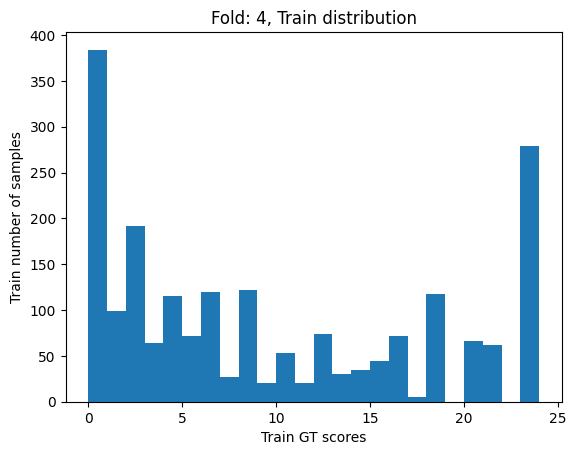

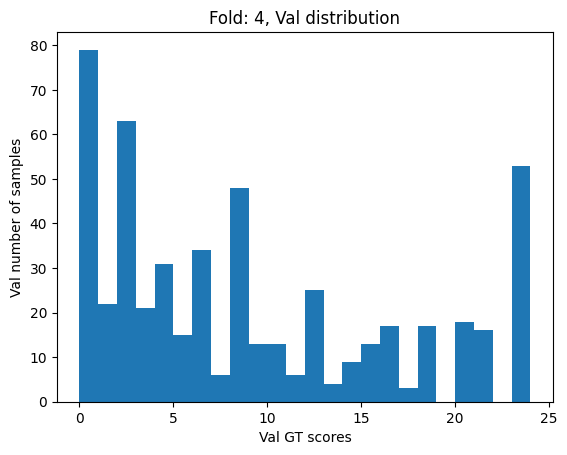

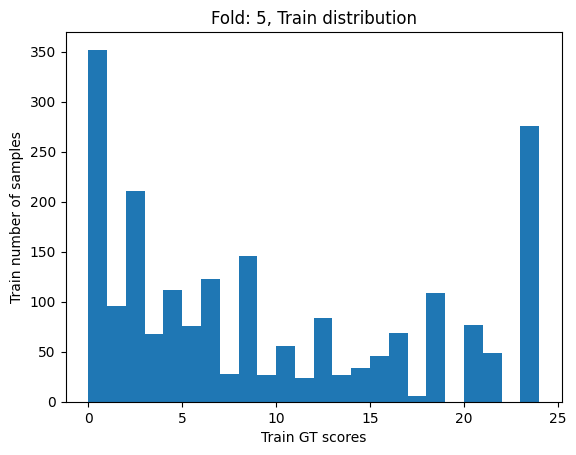

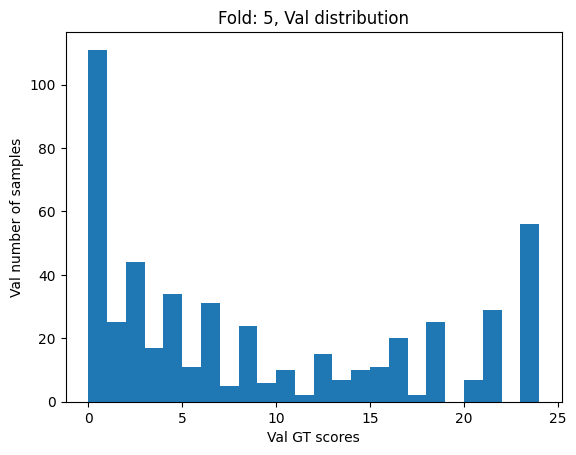

<Figure size 640x480 with 0 Axes>

In [8]:
with open('../data/label_info/labels.json',"r") as label_info:
    resized_json_file=json.load(label_info)
    
label_hist_scores=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24]
all_mrale_scores=[]
all_patient_ids=[]
for cur_info in resized_json_file:
    all_mrale_scores.append(cur_info['mRALE Score'])
    all_patient_ids.append(cur_info['PatientID'])
    
splitter=StratifiedGroupKFold(n_splits=5,random_state=48,shuffle=True) #THIS WILL TRY TO SPLIT THE DISTRIBUTION BETWEEN TRAIN, VALIDATION EVENLY BASED ON MRALE SCORES
for i, (train_idx,val_idx) in enumerate(splitter.split(resized_json_file,all_mrale_scores,all_patient_ids)):
    print("Fold: ",i+1)
    print("Train Indices:")
    print(len(train_idx))
    print("---------------")
    print("Val indices:")
    print(len(val_idx))
    print("-------------")    
    cur_fold_train_img_names=[]
    cur_fold_train_patient_ids=[]
    cur_fold_train_mrale_scores=[]
    
    cur_fold_val_img_names=[]
    cur_fold_val_patient_ids=[]
    cur_fold_val_mrale_scores=[]
    for cur_fold_train_idx in train_idx:
        cur_fold_train_patient_ids.append(resized_json_file[cur_fold_train_idx]['PatientID'])
        cur_fold_train_img_names.append(resized_json_file[cur_fold_train_idx]['full_image_name'])
        cur_fold_train_mrale_scores.append(resized_json_file[cur_fold_train_idx]['mRALE Score'])
        
    for cur_fold_val_idx in val_idx:
        cur_fold_val_patient_ids.append(resized_json_file[cur_fold_val_idx]['PatientID'])
        cur_fold_val_img_names.append(resized_json_file[cur_fold_val_idx]['full_image_name'])
        cur_fold_val_mrale_scores.append(resized_json_file[cur_fold_val_idx]['mRALE Score'])
        
    ###START: CONSISTENCY CHECK########
    ## THIS PORTION OF CODE WILL CHECK IF THERE IS ANY OVERLAP BETWEEN THE TRAIN AND VALIDATION IN-TERMS OF PATIENT_ID AND IMAGE_NAME FOR CURRENT FOLD
    for cur_train_img_name in cur_fold_train_img_names:
        if cur_train_img_name in cur_fold_val_img_names:
            print("!!!!!!!!!!!!!!Overlap in image level!!!!!!!!!")
    for cur_train_patient_id in cur_fold_train_patient_ids:
        if cur_train_patient_id in cur_fold_val_patient_ids:
            print("!!!!!!!!!!!!!!Overlap in patient level!!!!!!!!!")
    ###END: CONSISTENCY CHECK###########
    
    ### TODO: AT THIS POINT THE DATALOADER CAN BE INITIALIZED USING cur_fold_train_img_names, cur_fold_train_mrale_scores, cur_fold_val_img_names, cur_fold_val_mrale_scores
    
    
    plt.hist(cur_fold_train_mrale_scores,label_hist_scores)
    plt.xlabel("Train GT scores")
    plt.ylabel("Train number of samples")
    plt.title("Fold: "+str(i+1)+", Train distribution")
    
    
    plt.figure()
    plt.hist(cur_fold_val_mrale_scores,label_hist_scores)
    plt.xlabel("Val GT scores")
    plt.ylabel("Val number of samples")
    plt.title("Fold: "+str(i+1)+", Val distribution")
    plt.figure()
    

# Per-patient count

In [2]:
with open('../data/label_info/labels.json',"r") as label_info:
    label_info=json.load(label_info)

In [8]:
patient_count_dict=dict()
for cur_img_info in label_info:
    patient_count_dict[cur_img_info['PatientID']]=0
for cur_img_info in label_info:
    patient_count_dict[cur_img_info['PatientID']]+=1

    

In [9]:
patient_count_dict

{'419639-006447': 1,
 '419639-004301': 1,
 '419639-012467': 1,
 '10008204-i8Vlhy0EQ0iE9Yxc1i312g': 1,
 '10008204-wv3ZMzyHpEqRtnv7NXMv5g': 1,
 '10008204-jvhzOPDU00qXYWv7rLxCg': 1,
 '419639-008848': 11,
 '419639-008310': 1,
 '10008204-1dgQ83Ocf0CJpvB4MLkUUQ': 1,
 '419639-010537': 2,
 '419639-002175': 2,
 '419639-003921': 1,
 '10008204-QJ2gRJNTX0SXPjuN78QW3A': 14,
 '10008204-N8h3JTg70O6zNq8i7ptrw': 1,
 '419639-006912': 2,
 '419639-003943': 1,
 '419639-006688': 1,
 '419639-006808': 8,
 '419639-003894': 5,
 '10008204-QY84UPKX1ka2LJ1M22pVbg': 2,
 '419639-005800': 1,
 '419639-012631': 3,
 '419639-003444': 2,
 '419639-005960': 5,
 '419639-000501': 1,
 '419639-003577': 1,
 '419639-010082': 3,
 '10008204-OWs56IdJyEOYf7DOwKjcw': 2,
 '419639-007749': 1,
 '419639-007526': 1,
 '10008204-JFVCCzT9tUeonCTeiiNaqQ': 1,
 '419639-009075': 1,
 '419639-003680': 4,
 '10008204-bOd5o5YGkmWTeLO3rKvYw': 1,
 '419639-010722': 1,
 '419639-007222': 2,
 '10008204-KfwzDzBZUOg0bWMOK15jA': 1,
 '419639-000204': 1,
 '41963

In [14]:
multiple_count=0

images_per_patient=[]
for key in patient_count_dict.keys():
    if patient_count_dict[key]>1:
        multiple_count+=1
    images_per_patient.append(patient_count_dict[key])

In [20]:
len(images_per_patient)

1204

In [22]:
max(images_per_patient)

59

In [15]:
multiple_count

447

Text(0, 0.5, 'number of patient')

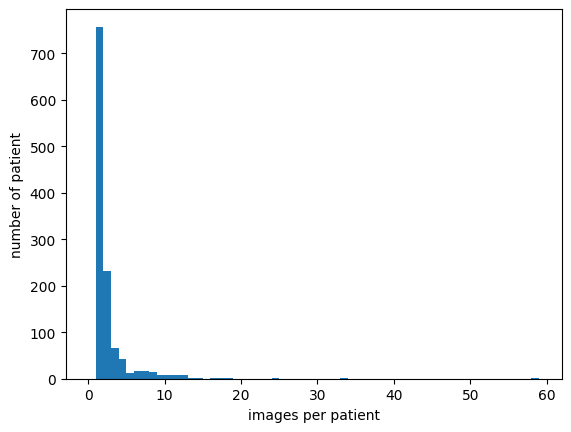

In [23]:
plt.hist(images_per_patient,[x for x in range(60)])
plt.xlabel("images per patient")
plt.ylabel("number of patient")

# Draft code to save val table

In [8]:
import statistics as stat
import pandas as pd
saved_metrics=pd.read_pickle(r'experiments/ResNet-50, Augment without cropping (epoch=50)/train_metrics.pkl')
to_save_val_results=[]
all_fold_loss=[]
all_fold_kappa=[]
for cur_fold in range(len(saved_metrics)):
    cur_fold_best_loss=1e10
    cur_fold_best_kappa=0
    for cur_fold_epoch in range(len(saved_metrics[cur_fold])):
        if saved_metrics[cur_fold][cur_fold_epoch]['Fold '+str(cur_fold+1)+' avg_vloss']<cur_fold_best_loss:
            cur_fold_best_loss=saved_metrics[cur_fold][cur_fold_epoch]['Fold '+str(cur_fold+1)+' avg_vloss']
            cur_fold_best_kappa=saved_metrics[cur_fold][cur_fold_epoch]['Fold '+str(cur_fold+1)+' avg_val_kappa']
    to_save_val_results.append([str(cur_fold+1),cur_fold_best_loss,cur_fold_best_kappa])
    all_fold_loss.append(cur_fold_best_loss)
    all_fold_kappa.append(cur_fold_best_kappa)
to_save_val_results.append(['mean',stat.mean(all_fold_loss),stat.mean(all_fold_kappa)])
to_save_val_results.append(['stdev',stat.stdev(all_fold_loss),stat.stdev(all_fold_kappa)])

to_save_val_results
            
            
            

[['1', 0.03738021105527878, 0.8087227712914449],
 ['2', 0.042512938380241394, 0.6984471444407615],
 ['3', 0.043951425701379776, 0.7494547662224267],
 ['4', 0.05031955987215042, 0.7112598342389123],
 ['5', 0.044554807245731354, 0.7502730875874234],
 ['mean', 0.04374378845095635, 0.7436315207561938],
 ['stdev', 0.004635508161582502, 0.04302454370752891]]

# Refined List of study-wise images containing multiple images for the studies

In [3]:
f=open('../data/label_info/labels.json')
label_json=json.load(f)

In [9]:
refined_study_images=[]
for cur_image in label_json:
    cur_image_pair_list=[]
    for seperate_image in label_json:
        if cur_image['StudyInstanceUID']==seperate_image['StudyInstanceUID'] and cur_image['full_image_name']!=seperate_image['full_image_name']:
            if seperate_image['full_image_name'] not in cur_image_pair_list:
                cur_image_pair_list.append(seperate_image['full_image_name'])
    if len(cur_image_pair_list)>1: #Means multiple image for this study
        cur_image_dict=dict()
        cur_image_dict['full_image_name']=cur_image['full_image_name']
        cur_image_dict['same_study_images']=cur_image_pair_list
        already_present=False
        for cur_same_study_image in cur_image_pair_list:
            if already_present==True:
                break
            for present_image in refined_study_images:
                if present_image['full_image_name']==cur_same_study_image:
                    already_present=True
                    break
        if already_present==False:
            refined_study_images.append(cur_image_dict)
print(len(refined_study_images))
with open('../data/label_info/refined_study_wise_images.json',"w") as study_image_list:
    json.dump(refined_study_images,study_image_list,indent=4)
            

55


# Patient wise-imagelist

In [12]:
refined_patient_images=[]
for cur_image in label_json:
    cur_image_pair_list=[]
    for seperate_image in label_json:
        if cur_image['PatientID']==seperate_image['PatientID'] and cur_image['full_image_name']!=seperate_image['full_image_name']:
            if seperate_image['full_image_name'] not in cur_image_pair_list:
                cur_image_pair_list.append(seperate_image['full_image_name'])
    if len(cur_image_pair_list)>1: #Means multiple image for this patient
        cur_image_dict=dict()
        cur_image_dict['full_image_name']=cur_image['full_image_name']
        cur_image_dict['same_patient_images']=cur_image_pair_list
        already_present=False
        for cur_same_patient_image in cur_image_pair_list:
            if already_present==True:
                break
            for present_image in refined_patient_images:
                if present_image['full_image_name']==cur_same_patient_image:
                    already_present=True
                    break
        if already_present==False:
            refined_patient_images.append(cur_image_dict)
print(len(refined_patient_images))
with open('../data/label_info/refined_patient_wise_images.json',"w") as patient_image_list:
    json.dump(refined_patient_images,patient_image_list,indent=4)
            

216


# TorchXrayVision debug

In [6]:
import torchxrayvision as xrv
model=xrv.models.ResNet(weights="resnet50-res512-all")
for m in model.modules():
    print(m)

XRV-ResNet-resnet50-res512-all
ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, 

In [9]:
for m in model.named_modules():
    print(m)

('', XRV-ResNet-resnet50-res512-all)
('model', ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): 

In [15]:
print(model.model.fc.in_features)

2048
